# Modellwahl

Wähle hier das gewünschte Modell: `"6B"`, `"300M"` oder `"combined"`.

In [1]:
model_choice = "6B" # Optionen: "6B", "300M", "combined"

# Imports and Setup

Lade alle benötigten Bibliotheken, setze das Gerät (CPU/GPU) und zeige die gewählte Modellvariante an.

In [2]:
import numpy as np
import time
import itertools
from collections import OrderedDict
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, RocCurveDisplay, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Globale Seed-Funktion für Reproduzierbarkeit
def set_seed(seed=42):
    """Setzt alle relevanten Seeds für Reproduzierbarkeit"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Alle Seeds auf {seed} gesetzt")

# Seeds setzen
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} | Model choice: {model_choice}")

Alle Seeds auf 42 gesetzt
Using device: cuda | Model choice: 6B


# Daten laden und Label-Encoding

- Lade die 6B- und 300M-Embeddings.
- Enkodiere die Labels.
- Wähle Features entsprechend `model_choice`.

In [3]:
# 6B Embedding + Labels
data6B = np.load('../data/esmc-embeddings/embeddings_complete_6B_80.npz', allow_pickle=True)
X_6B   = data6B['embeddings']   # (1250, 2560)
Y      = data6B['labels']       # (1250,)

# 300M Embedding
data300M = np.load('../data/esmc-embeddings/embeddings_complete.npz', allow_pickle=True)
X_300M   = data300M['embeddings']  # (1250, 31, 960)

# Label-Encoding
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Feature-Auswahl je Modellwahl
if model_choice == "6B":
    X_feat = X_6B                                    # (1250, 2560)
elif model_choice == "300M":
    X_feat = X_300M.mean(axis=1)                    # (1250, 960)
elif model_choice == "combined":
    X_300M_feat = X_300M.mean(axis=1)               # (1250, 960)
    X_feat = np.concatenate([X_6B, X_300M_feat], axis=1)  # (1250, 3520)
else:
    raise ValueError("model_choice muss '6B', '300M' oder 'combined' sein")

print("Feature shape:", X_feat.shape, "Labels shape:", Y_encoded.shape)

Feature shape: (1250, 2560) Labels shape: (1250,)


# Train/Validation/Test-Split und Skalierung

- 25 % der Daten als Testset, davon 20 % für die Validierung.
- Standardisierung auf Trainingsdaten fitten und anwenden.

In [4]:
# Split: 25% Test, davon 20% Val
X_tr, X_te, y_tr, y_te = train_test_split(
    X_feat, Y_encoded, test_size=0.25, random_state=42, stratify=Y_encoded
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr, y_tr, test_size=0.2, random_state=42, stratify=y_tr
)

# Standardisierung
scaler = StandardScaler().fit(X_tr)
X_tr_s  = scaler.transform(X_tr)
X_val_s = scaler.transform(X_val)
X_te_s  = scaler.transform(X_te)

# DataLoader mit WeightedRandomSampler

Behebe Klassenungleichgewicht mithilfe gewichteter Stichproben im Training.

In [5]:
# Deterministischer DataLoader
def create_dataloaders(X_tr_s, y_tr, X_val_s, y_val, batch_size, seed=42):
    set_seed(seed)

    # Tensor-Konvertierung
    X_tr_t = torch.from_numpy(X_tr_s).float()
    y_tr_t = torch.from_numpy(y_tr).long()
    X_val_t = torch.from_numpy(X_val_s).float()
    y_val_t = torch.from_numpy(y_val).long()

    # Klassengewichte
    counts = np.bincount(y_tr)
    inv_freq = 1.0 / counts
    sample_weights = inv_freq[y_tr]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True,
        generator=torch.Generator().manual_seed(seed)
    )

    train_loader = DataLoader(
        TensorDataset(X_tr_t, y_tr_t),
        batch_size=batch_size,
        sampler=sampler,
        worker_init_fn=lambda worker_id: set_seed(seed + worker_id),
        generator=torch.Generator().manual_seed(seed)
    )

    val_loader = DataLoader(
        TensorDataset(X_val_t, y_val_t),
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, val_loader, counts, inv_freq

# DataLoader erstellen
train_loader, val_loader, counts, inv_freq = create_dataloaders(X_tr_s, y_tr, X_val_s, y_val, batch_size=32, seed=42)

Alle Seeds auf 42 gesetzt


# MLP-Modell definieren

Ein mehrschichtiges Perzeptron mit variablen Hidden-Layern und Dropout.

In [6]:
# MLP-Definition
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, output_dim, dropout_rate):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.extend([nn.Linear(in_dim, h), nn.ReLU(), nn.Dropout(dropout_rate)])
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Focal Loss

Implementierung der Focal Loss zur besseren Behandlung von Klassenungleichgewicht.

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha     = alpha
        self.gamma     = gamma
        self.reduction = reduction

    def forward(self, logits, target):
        ce_loss = F.cross_entropy(logits, target, weight=self.alpha, reduction='none')
        p_t     = torch.exp(-ce_loss)
        loss    = (1 - p_t)**self.gamma * ce_loss
        if self.reduction == 'mean':
            return loss.mean()
        if self.reduction == 'sum':
            return loss.sum()
        return loss

# Trainingsfunktion mit Early Stopping

`train_model` übernimmt Training, Validierung, Early Stopping und ReduceLROnPlateau.

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs, patience, device, seed=None):
    if seed is not None:
        set_seed(seed)

    model.to(device)
    best_state = None
    best_f1 = 0.0
    no_improve = 0

    for epoch in range(1, num_epochs + 1):
        # Training Phase
        model.train()
        total_loss = 0.0
        preds_tr, trues_tr = [], []

        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(Xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            p = torch.argmax(logits, dim=1).cpu().numpy()
            preds_tr.extend(p)
            trues_tr.extend(yb.cpu().numpy())

        # Validation Phase
        model.eval()
        val_loss = 0.0
        preds_val, trues_val = [], []
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                logits = model(Xb)
                loss = criterion(logits, yb)
                val_loss += loss.item()
                p = torch.argmax(logits, dim=1).cpu().numpy()
                preds_val.extend(p)
                trues_val.extend(yb.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        val_f1 = f1_score(trues_val, preds_val, average='macro')
        if val_f1 > best_f1 + 1e-4:
            best_f1 = val_f1
            best_state = model.state_dict().copy()
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"→ Early stopping nach {epoch} Epochen.")
            break

        if epoch == 1 or epoch % 25 == 0:
            lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}/{num_epochs} | LR={lr:.1e} | Val Macro-F1={val_f1:.4f}")

    model.load_state_dict(best_state)
    return model

# Modell-Evaluation

`evaluate_model` gibt Accuracy, Klassifikationsbericht und Konfusionsmatrix zurück.


In [9]:
def evaluate_model(model, X_np, y_np, device):
    model.to(device).eval()
    with torch.no_grad():
        logits = model(torch.from_numpy(X_np).float().to(device))
        preds  = torch.argmax(logits, dim=1).cpu().numpy()
    acc    = np.mean(preds == y_np)
    report = classification_report(y_np, preds, target_names=label_encoder.classes_)
    cm     = confusion_matrix(y_np, preds)
    return acc, report, cm

# Hyperparameter-Optimierung

Die Hyperparameter-Optimierung wird hier mit Grid-Search durchgeführt, um die besten Hyperparameter für das MLP-Modell zu finden. Dabei werden verschiedene Kombinationen von Hyperparametern getestet und die beste Konfiguration basierend auf der Validierungs-Macro-F1-Score ausgewählt. Optimiert wird auf basis der ESMC 6B Embeddings. Für andere Modelle (z.B. 300M) wurde nicht weiter optimiert.

Die Optimierung liefert folgende Hyperparameter:
=== Best Params ===
{'hidden_sizes': [2048, 1024, 512, 256], 'dropout_rate': 0.0, 'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 32, 'gamma': 2.0, 'num_epochs': 64} → Macro-F1: 0.528715634647838

In [ ]:
import itertools
# Search-Space (auskommentiert für normale Verwendung)
"""
param_grid = {
    'hidden_sizes': [
        [512, 256],                    # flach & schmal
        [1024, 512, 256],              # mittel
        [2048, 1024, 512, 256],        # tiefer & breiter
        [1024, 512, 256, 128, 64]      # sehr tief
    ],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4],
    'lr': [1e-5, 1e-4, 5e-4, 1e-3, 5e-3],
    'weight_decay': [1e-5, 1e-4, 1e-3],
    'batch_size': [16, 32, 64],
    'gamma': [0.5, 1.0, 2.0, 3.0],
    'num_epochs': [64, 128]
}
"""
print("Hyperparameter-Optimierung übersprungen. Verwende optimierte Parameter.")

In [ ]:
# Hilfsfunktion: ein Modell für gegebene Params trainieren & evaluieren
def evaluate_params(params):
    # Modell neu initialisieren
    model = MLP(
        input_dim=X_tr_s.shape[1],
        hidden_sizes=params['hidden_sizes'],
        output_dim=len(label_encoder.classes_),
        dropout_rate=params['dropout_rate']
    ).to(device)
    optimizer = optim.Adam(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['weight_decay']
    )
    # plateaubasierter LR-Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    # Loss mit class weights
    class_w   = torch.from_numpy(inv_freq / inv_freq.sum() * len(class_counts)).float().to(device)
    criterion = FocalLoss(alpha=class_w, gamma=2.0)

    # Trainieren
    train_model(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        num_epochs=100,    # für Search evtl weniger Epochen
        patience=10,
        device=device
    )

    # Auf Validation-Set evaluieren
    _, report, _ = evaluate_model(model, X_val_s, y_val, device)
    # Macro-F1 aus dem Report extrahieren
    with torch.no_grad():
        logits = model(torch.from_numpy(X_val_s).float().to(device))
        preds  = torch.argmax(logits, dim=1).cpu().numpy()
    return f1_score(y_val, preds, average='macro')


In [ ]:
# Grid-Search über alle Kombinationen
best_score = 0.0
best_params = None

# Erzeuge alle Kombinationen
keys, values = zip(*param_grid.items())
for vals in itertools.product(*values):
    params = dict(zip(keys, vals))
    print("Testing:", params)
    score = evaluate_params(params)
    print(f"→ Val Macro-F1: {score:.4f}\n")
    if score > best_score:
        best_score, best_params = score, params

print("=== Best Params ===")
print(best_params, "→ Macro-F1:", best_score)

# Training des FocalLoss-Modells

In [10]:
# Hyperparameter
input_size   = X_feat.shape[1]
hidden_sizes = [2048, 1024, 512, 256]
output_size  = len(label_encoder.classes_)
lr           = 1e-3
weight_decay = 1e-5
batch_size   = 32
gamma        = 2.0
num_epochs   = 64
dropout_rate = 0.0
patience     = 20

# Modell, Loss, Optimizer, Scheduler
set_seed(42)
model = MLP(input_size, hidden_sizes, output_size, dropout_rate).to(device)
class_w = torch.from_numpy(inv_freq / inv_freq.sum() * len(counts)).float().to(device)
criterion = FocalLoss(alpha=class_w, gamma=gamma)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training
print(f"\n» Training {model_choice}-Modell (FocalLoss)")
train_model(model, train_loader, val_loader,
            criterion, optimizer, scheduler,
            num_epochs, patience, device, seed=42)

# Evaluation
acc, report, cm = evaluate_model(model, X_te_s, y_te, device)
print(f"\n» {model_choice} Test-Accuracy: {acc:.4f}")
print(report)
print("Confusion Matrix:\n", cm)

Alle Seeds auf 42 gesetzt

» Training 6B-Modell (FocalLoss)
Alle Seeds auf 42 gesetzt
Epoch 1/64 | LR=1.0e-03 | Val Macro-F1=0.3720
Epoch 25/64 | LR=1.3e-04 | Val Macro-F1=0.4655
→ Early stopping nach 34 Epochen.

» 6B Test-Accuracy: 0.5080
              precision    recall  f1-score   support

       early       0.57      0.55      0.56       130
        late       0.50      0.59      0.54       104
      middle       0.40      0.33      0.36        79

    accuracy                           0.51       313
   macro avg       0.49      0.49      0.49       313
weighted avg       0.50      0.51      0.50       313

Confusion Matrix:
 [[72 32 26]
 [30 61 13]
 [25 28 26]]


# Training des MultiMarginLoss-Modells

In [14]:
# Test mit MultiMarginLoss
input_size   = X_feat.shape[1]
hidden_sizes = [2048, 1024, 512, 256]
output_size  = len(label_encoder.classes_)
lr           = 1e-3
weight_decay = 1e-5
num_epochs   = 64
batch_size   = 32
dropout_rate = 0.0
patience     = 20

# Modell neu initialisieren
set_seed(42)
model_margin = MLP(input_size, hidden_sizes, output_size, dropout_rate).to(device)

# Criterion = MultiMarginLoss
criterion_margin = nn.MultiMarginLoss()

# Optimizer & Scheduler
optimizer_margin = optim.Adam(
    model_margin.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
scheduler_margin = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_margin, mode='min', factor=0.5, patience=5
)

# Training
start = time.time()
print("→ Training mit MultiMarginLoss")
train_model(
    model_margin,
    train_loader,
    val_loader,
    criterion_margin,
    optimizer_margin,
    scheduler_margin,
    num_epochs,
    patience,
    device,
    seed=42
)
duration = time.time() - start
print(f"Training fertig in {duration:.1f} s\n")

# Evaluation
acc_m, report_m, cm_m = evaluate_model(model_margin, X_te_s, y_te, device)
print(">>> Ergebnisse mit MultiMarginLoss:")
print(f"Test-Accuracy: {acc_m:.4f}")
print(report_m)
print("Confusion Matrix:\n", cm_m)

Alle Seeds auf 42 gesetzt
→ Training mit MultiMarginLoss
Alle Seeds auf 42 gesetzt
Epoch 1/64 | LR=1.0e-03 | Val Macro-F1=0.4607
Epoch 25/64 | LR=6.3e-05 | Val Macro-F1=0.4415
→ Early stopping nach 28 Epochen.
Training fertig in 3.9 s

>>> Ergebnisse mit MultiMarginLoss:
Test-Accuracy: 0.4984
              precision    recall  f1-score   support

       early       0.56      0.54      0.55       130
        late       0.47      0.57      0.52       104
      middle       0.44      0.34      0.38        79

    accuracy                           0.50       313
   macro avg       0.49      0.48      0.48       313
weighted avg       0.50      0.50      0.50       313

Confusion Matrix:
 [[70 37 23]
 [33 59 12]
 [23 29 27]]


# Visualisierung FocalLoss-Modell

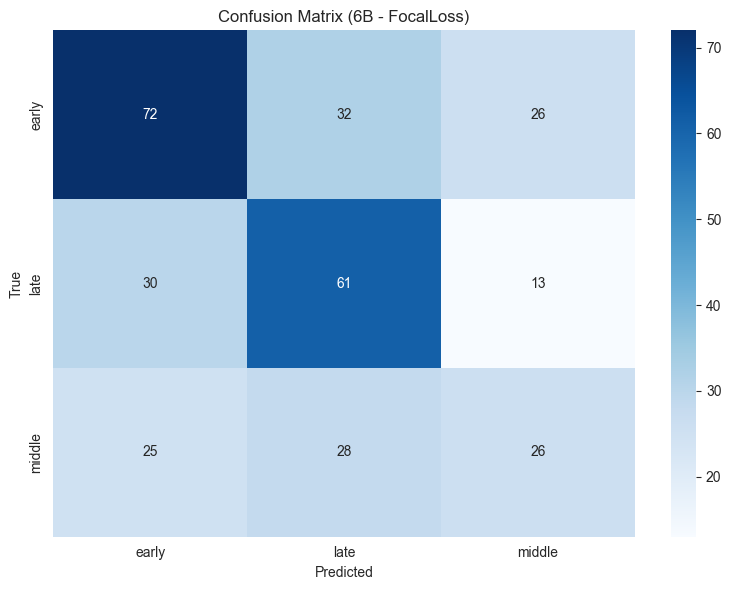

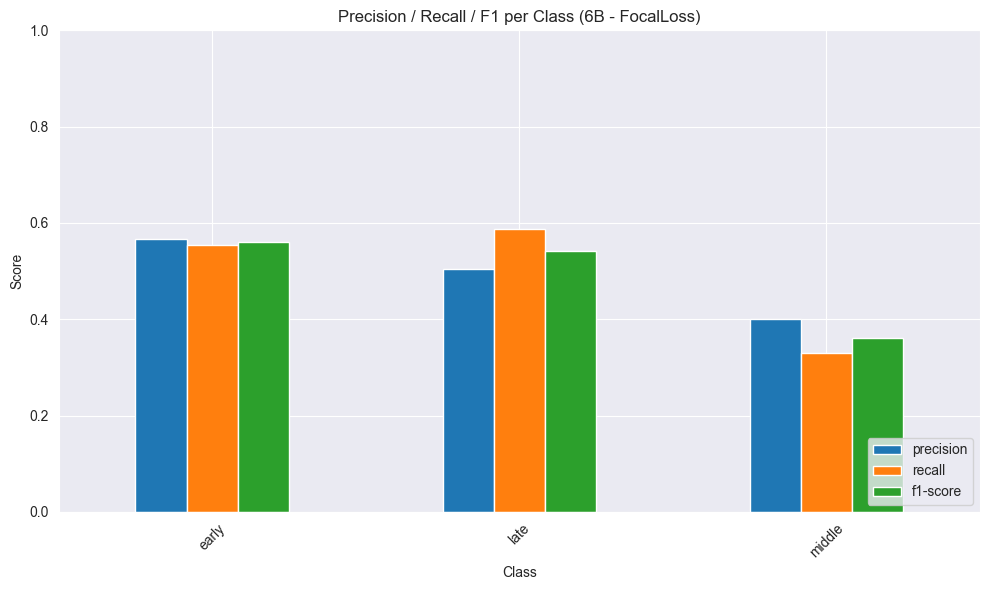

C:\Users\Tim\Desktop\bold-binders\.venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
C:\Users\Tim\Desktop\bold-binders\.venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
C:\Users\Tim\Desktop\bold-binders\.venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


<Figure size 800x800 with 0 Axes>

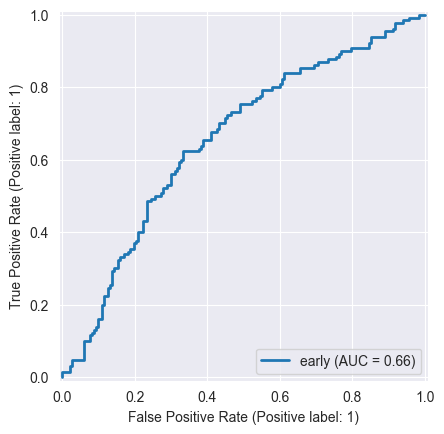

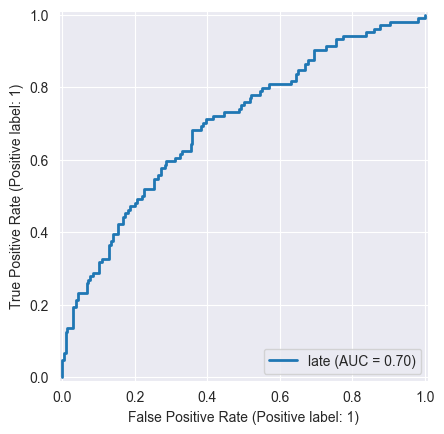

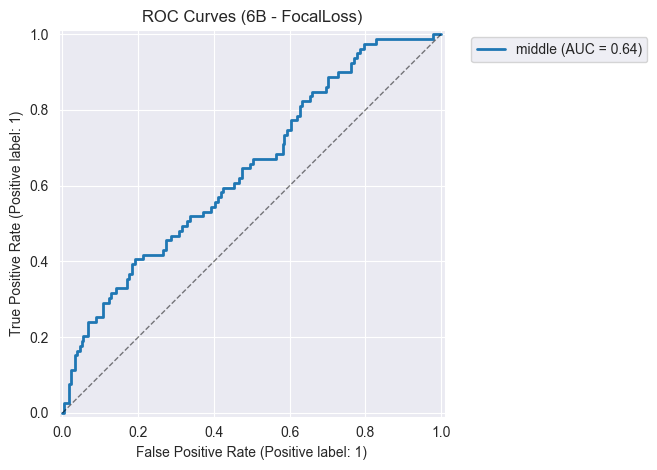

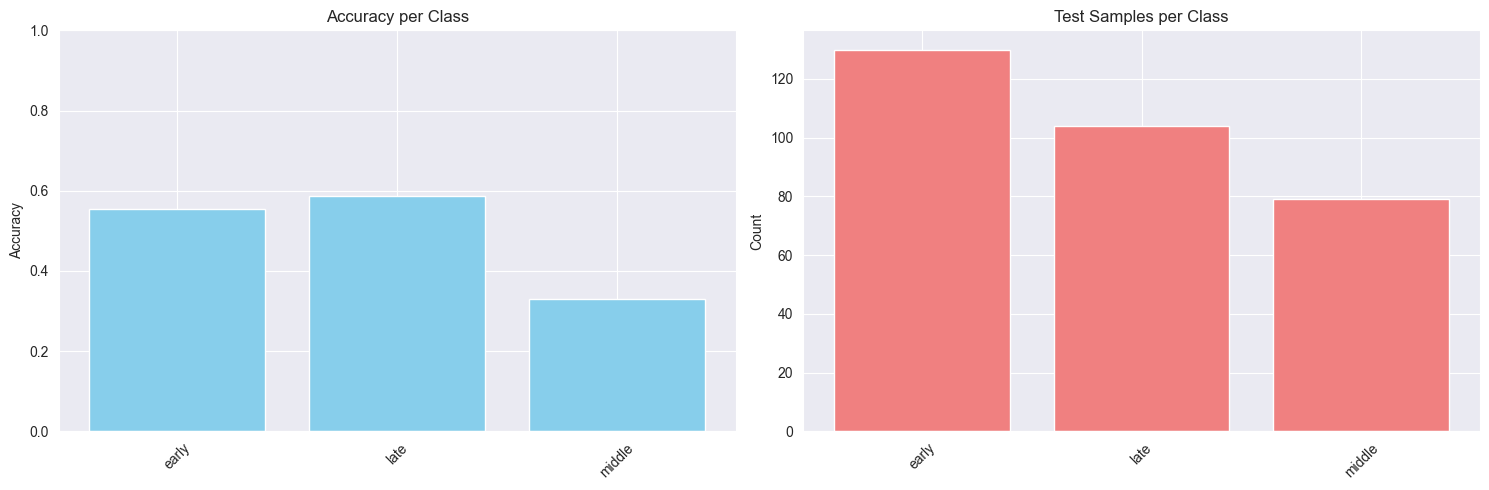


» Modell-Zusammenfassung (6B - FocalLoss):
   Gesamte Test-Accuracy: 0.5080
   Durchschnittliche Klassen-Accuracy: 0.4898
   Anzahl Parameter: 8,000,003


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch.nn.functional as F
from sklearn.metrics import classification_report, RocCurveDisplay

# 1) Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f"Confusion Matrix ({model_choice} - FocalLoss)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# 2) Classification Report als Bar-Chart
report_dict = classification_report(y_te,
                                   torch.argmax(model(torch.from_numpy(X_te_s).float().to(device)), 1).cpu().numpy(),
                                   target_names=label_encoder.classes_,
                                   output_dict=True)
df_report = pd.DataFrame(report_dict).transpose().iloc[:-3, :3]
df_report.plot(kind='bar', figsize=(10,6))
plt.ylim(0,1)
plt.title(f"Precision / Recall / F1 per Class ({model_choice} - FocalLoss)")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 3) ROC-Kurven (one-vs-rest)
X_te_t = torch.from_numpy(X_te_s).float().to(device)
with torch.no_grad():
    model.eval()
    probs = F.softmax(model(X_te_t), dim=1).cpu().numpy()

plt.figure(figsize=(8,8))
for i, cls in enumerate(label_encoder.classes_):
    RocCurveDisplay.from_predictions(
        (y_te == i).astype(int), probs[:, i], name=cls, linewidth=2
    )
plt.plot([0,1],[0,1], 'k--', linewidth=1, alpha=0.5)
plt.title(f"ROC Curves ({model_choice} - FocalLoss)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4) Klassen-Performance Übersicht
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Accuracy pro Klasse
class_acc = []
for i in range(len(label_encoder.classes_)):
    mask = (y_te == i)
    if mask.sum() > 0:
        y_pred = torch.argmax(model(X_te_t), 1).cpu().numpy()
        acc_i = (y_pred[mask] == y_te[mask]).mean()
        class_acc.append(acc_i)
    else:
        class_acc.append(0)

ax1.bar(label_encoder.classes_, class_acc, color='skyblue')
ax1.set_title('Accuracy per Class')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=45)

# Support (Anzahl Samples) pro Klasse
class_counts = [np.sum(y_te == i) for i in range(len(label_encoder.classes_))]
ax2.bar(label_encoder.classes_, class_counts, color='lightcoral')
ax2.set_title('Test Samples per Class')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n» Modell-Zusammenfassung ({model_choice} - FocalLoss):")
print(f"   Gesamte Test-Accuracy: {acc:.4f}")
print(f"   Durchschnittliche Klassen-Accuracy: {np.mean(class_acc):.4f}")
print(f"   Anzahl Parameter: {sum(p.numel() for p in model.parameters()):,}")

# Visualisierung MultiMarginLoss-Modell

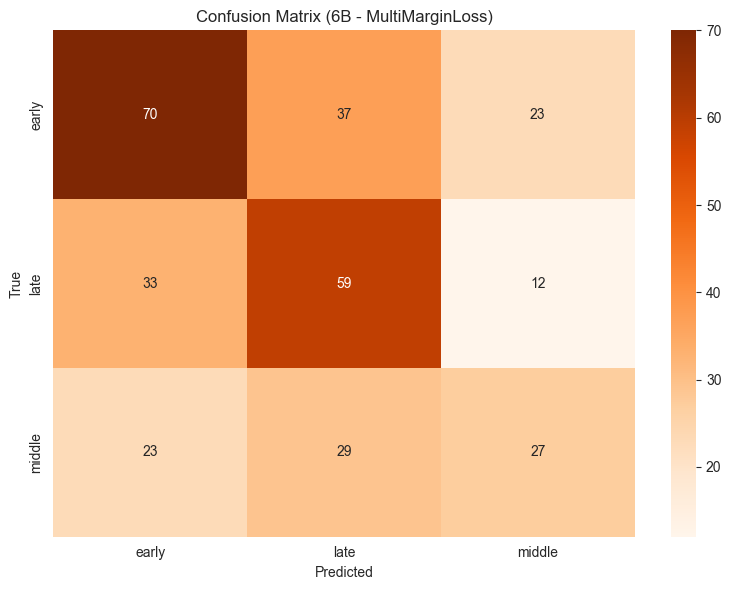

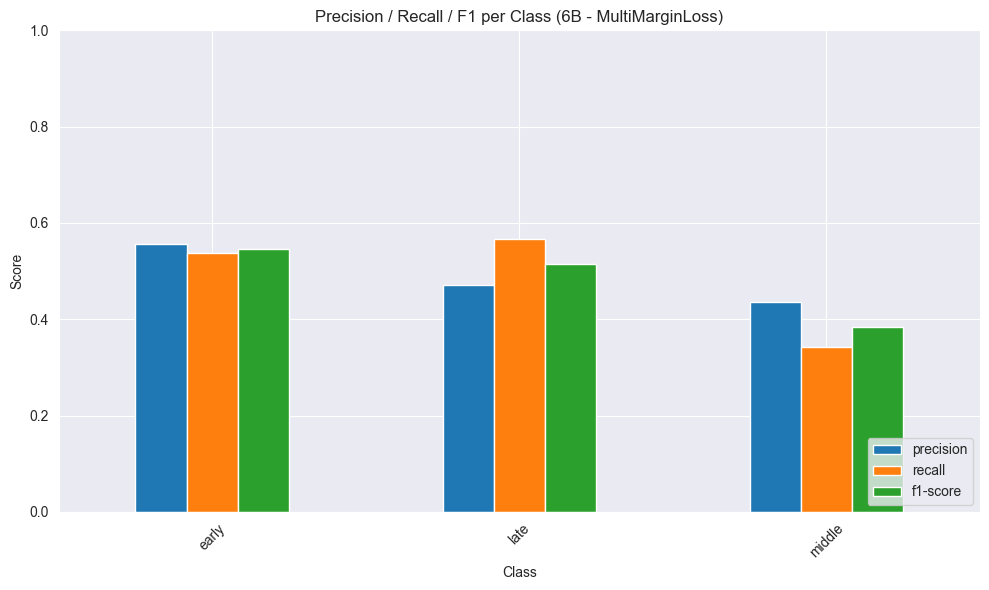

C:\Users\Tim\Desktop\bold-binders\.venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
C:\Users\Tim\Desktop\bold-binders\.venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
C:\Users\Tim\Desktop\bold-binders\.venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


<Figure size 800x800 with 0 Axes>

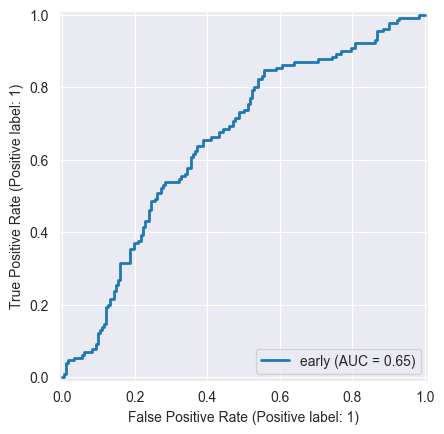

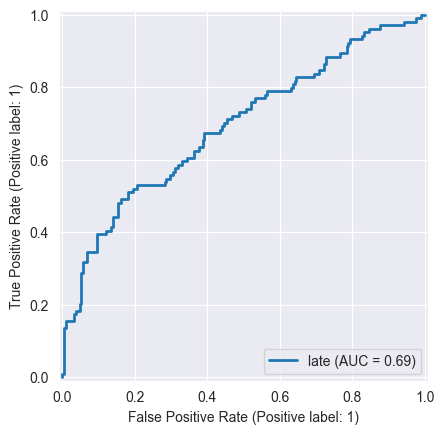

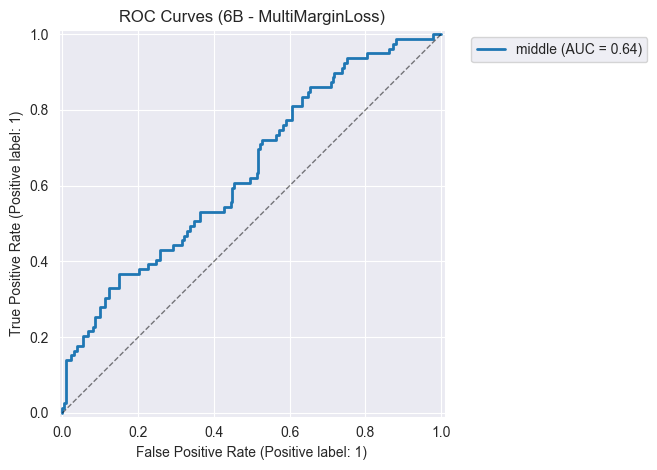

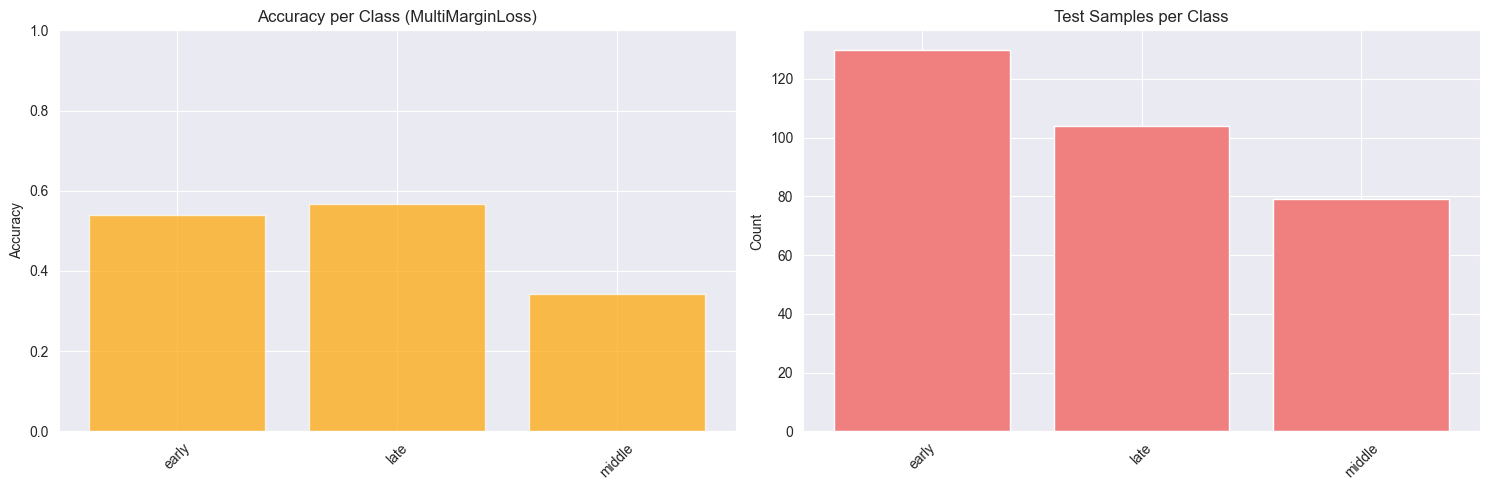


» Modell-Zusammenfassung (6B - MultiMarginLoss):
   Gesamte Test-Accuracy: 0.4984
   Durchschnittliche Klassen-Accuracy: 0.4825
   Anzahl Parameter: 8,000,003


In [17]:
# %% Visualisierung für MultiMarginLoss-Ergebnisse %%
# Vorhersagen des MultiMarginLoss-Modells erstellen
y_pred_margin = torch.argmax(model_margin(torch.from_numpy(X_te_s).float().to(device)), 1).cpu().numpy()

# 1) Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_m, annot=True, fmt="d", cmap="Oranges",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f"Confusion Matrix ({model_choice} - MultiMarginLoss)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# 2) Classification Report als Bar-Chart
report_dict = classification_report(y_te, y_pred_margin,
                                   target_names=label_encoder.classes_,
                                   output_dict=True)
df_report = pd.DataFrame(report_dict).transpose().iloc[:-3, :3]
df_report.plot(kind='bar', figsize=(10,6))
plt.ylim(0,1)
plt.title(f"Precision / Recall / F1 per Class ({model_choice} - MultiMarginLoss)")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 3) ROC-Kurven (one-vs-rest)
X_te_t = torch.from_numpy(X_te_s).float().to(device)
with torch.no_grad():
    model_margin.eval()
    probs = F.softmax(model_margin(X_te_t), dim=1).cpu().numpy()

plt.figure(figsize=(8,8))
for i, cls in enumerate(label_encoder.classes_):
    RocCurveDisplay.from_predictions(
        (y_te == i).astype(int), probs[:, i], name=cls, linewidth=2
    )
plt.plot([0,1],[0,1], 'k--', linewidth=1, alpha=0.5)
plt.title(f"ROC Curves ({model_choice} - MultiMarginLoss)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4) Klassen-Performance Übersicht
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Accuracy pro Klasse
class_acc_margin = []
for i in range(len(label_encoder.classes_)):
    mask = (y_te == i)
    if mask.sum() > 0:
        acc_i = (y_pred_margin[mask] == y_te[mask]).mean()
        class_acc_margin.append(acc_i)
    else:
        class_acc_margin.append(0)

ax1.bar(label_encoder.classes_, class_acc_margin, color='orange', alpha=0.7)
ax1.set_title('Accuracy per Class (MultiMarginLoss)')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=45)

# Support (Anzahl Samples) pro Klasse
class_counts = [np.sum(y_te == i) for i in range(len(label_encoder.classes_))]
ax2.bar(label_encoder.classes_, class_counts, color='lightcoral')
ax2.set_title('Test Samples per Class')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n» Modell-Zusammenfassung ({model_choice} - MultiMarginLoss):")
print(f"   Gesamte Test-Accuracy: {acc_m:.4f}")
print(f"   Durchschnittliche Klassen-Accuracy: {np.mean(class_acc_margin):.4f}")
print(f"   Anzahl Parameter: {sum(p.numel() for p in model_margin.parameters()):,}")


# Ensemble-Training FocalLoss

In [18]:
# Helper-Funktion: trainiere ein FocalLoss-Modell mit gegebenem Seed
def train_focal_seed_model(seed, base_seed=42):
    effective_seed = base_seed + seed
    set_seed(effective_seed)

    # DataLoader mit spezifischem Seed
    train_loader_seed, val_loader_seed, _, _ = create_dataloaders(
        X_tr_s, y_tr, X_val_s, y_val, batch_size=32, seed=effective_seed
    )

    mdl = MLP(input_size, hidden_sizes, output_size, dropout_rate).to(device)
    opt = optim.Adam(mdl.parameters(), lr=lr, weight_decay=weight_decay)
    crit = FocalLoss(alpha=class_w, gamma=2.0)
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)

    train_model(mdl, train_loader_seed, val_loader_seed,
                crit, opt, sched, num_epochs, patience, device, seed=effective_seed)
    return mdl

# Mehrere Modelle mit unterschiedlichen Seeds trainieren
seeds = [0, 1, 2, 3, 4]
ensemble_focal = [train_focal_seed_model(s, base_seed=42) for s in seeds]

# Soft-Voting-Funktion
def ensemble_predict(models, X_np):
    X_t = torch.from_numpy(X_np).float().to(device)
    probs = []
    with torch.no_grad():
        for m in models:
            m.eval()
            p = F.softmax(m(X_t), dim=1).cpu().numpy()
            probs.append(p)
    avg_p = np.mean(probs, axis=0)
    return avg_p.argmax(axis=1)

# Ensemble-Vorhersage und Auswertung
y_pred_ens_focal = ensemble_predict(ensemble_focal, X_te_s)

print(f"\n» Ensemble ({model_choice}) FocalLoss Test-Performance:")
print(classification_report(y_te, y_pred_ens_focal, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred_ens_focal))
print(f"Accuracy: {np.mean(y_pred_ens_focal==y_te):.4f}")

Alle Seeds auf 42 gesetzt
Alle Seeds auf 42 gesetzt
Alle Seeds auf 42 gesetzt
Epoch 1/64 | LR=1.0e-03 | Val Macro-F1=0.3720
Epoch 25/64 | LR=1.3e-04 | Val Macro-F1=0.4655
→ Early stopping nach 34 Epochen.
Alle Seeds auf 43 gesetzt
Alle Seeds auf 43 gesetzt
Alle Seeds auf 43 gesetzt
Epoch 1/64 | LR=1.0e-03 | Val Macro-F1=0.3277
Epoch 25/64 | LR=6.3e-05 | Val Macro-F1=0.5180
→ Early stopping nach 44 Epochen.
Alle Seeds auf 44 gesetzt
Alle Seeds auf 44 gesetzt
Alle Seeds auf 44 gesetzt
Epoch 1/64 | LR=1.0e-03 | Val Macro-F1=0.3043
Epoch 25/64 | LR=6.3e-05 | Val Macro-F1=0.4847
→ Early stopping nach 46 Epochen.
Alle Seeds auf 45 gesetzt
Alle Seeds auf 45 gesetzt
Alle Seeds auf 45 gesetzt
Epoch 1/64 | LR=1.0e-03 | Val Macro-F1=0.2679
Epoch 25/64 | LR=1.3e-04 | Val Macro-F1=0.4702
→ Early stopping nach 35 Epochen.
Alle Seeds auf 46 gesetzt
Alle Seeds auf 46 gesetzt
Alle Seeds auf 46 gesetzt
Epoch 1/64 | LR=1.0e-03 | Val Macro-F1=0.3024
Epoch 25/64 | LR=6.3e-05 | Val Macro-F1=0.4676
→ Early s

# Ensemble-Training MultiMarginLoss

In [19]:
# Helper-Funktion: trainiere ein MultiMarginLoss-Modell mit gegebenem Seed
def train_margin_seed_model(seed, base_seed=42):
    effective_seed = base_seed + seed
    set_seed(effective_seed)

    # DataLoader mit spezifischem Seed
    train_loader_seed, val_loader_seed, _, _ = create_dataloaders(
        X_tr_s, y_tr, X_val_s, y_val, batch_size=32, seed=effective_seed
    )

    mdl = MLP(input_size, hidden_sizes, output_size, dropout_rate=0.0).to(device)
    opt = optim.Adam(mdl.parameters(), lr=lr, weight_decay=1e-5)
    crit = nn.MultiMarginLoss()
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)

    train_model(mdl, train_loader_seed, val_loader_seed,
                crit, opt, sched, num_epochs, patience, device, seed=effective_seed)
    return mdl

# Mehrere Modelle mit unterschiedlichen Seeds trainieren
ensemble_margin = [train_margin_seed_model(s, base_seed=42) for s in seeds]

# Ensemble-Vorhersage und Auswertung
y_pred_ens_margin = ensemble_predict(ensemble_margin, X_te_s)

print(f"\n» Ensemble ({model_choice}) MultiMarginLoss Test-Performance:")
print(classification_report(y_te, y_pred_ens_margin, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred_ens_margin))
print(f"Accuracy: {np.mean(y_pred_ens_margin == y_te):.4f}")

Alle Seeds auf 42 gesetzt
Alle Seeds auf 42 gesetzt
Alle Seeds auf 42 gesetzt
Epoch 1/64 | LR=1.0e-03 | Val Macro-F1=0.4352
Epoch 25/64 | LR=1.3e-04 | Val Macro-F1=0.4419
→ Early stopping nach 29 Epochen.
Alle Seeds auf 43 gesetzt
Alle Seeds auf 43 gesetzt
Alle Seeds auf 43 gesetzt
Epoch 1/64 | LR=1.0e-03 | Val Macro-F1=0.4418
→ Early stopping nach 22 Epochen.
Alle Seeds auf 44 gesetzt
Alle Seeds auf 44 gesetzt
Alle Seeds auf 44 gesetzt
Epoch 1/64 | LR=1.0e-03 | Val Macro-F1=0.3605
Epoch 25/64 | LR=6.3e-05 | Val Macro-F1=0.4169
→ Early stopping nach 29 Epochen.
Alle Seeds auf 45 gesetzt
Alle Seeds auf 45 gesetzt
Alle Seeds auf 45 gesetzt
Epoch 1/64 | LR=1.0e-03 | Val Macro-F1=0.4026
Epoch 25/64 | LR=1.3e-04 | Val Macro-F1=0.4752
→ Early stopping nach 49 Epochen.
Alle Seeds auf 46 gesetzt
Alle Seeds auf 46 gesetzt
Alle Seeds auf 46 gesetzt
Epoch 1/64 | LR=1.0e-03 | Val Macro-F1=0.4236
→ Early stopping nach 23 Epochen.

» Ensemble (6B) MultiMarginLoss Test-Performance:
              prec

# Vergleich FocalLoss: Single vs Ensemble

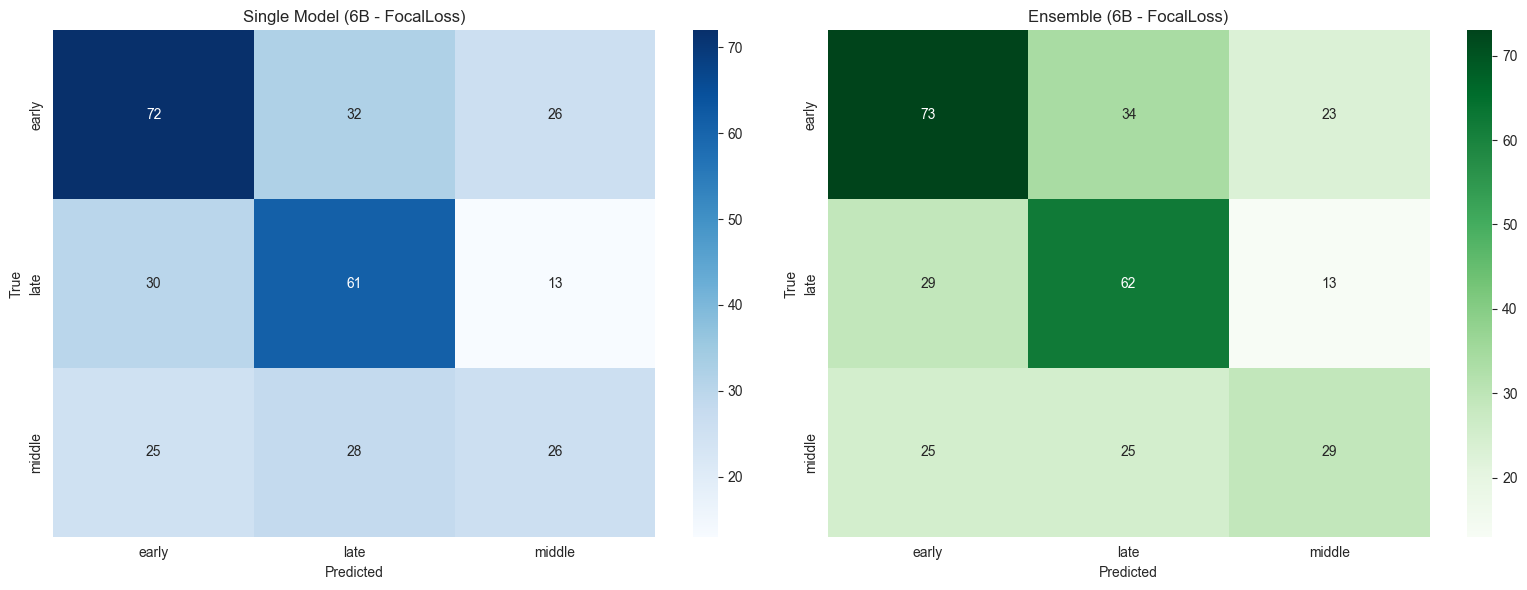

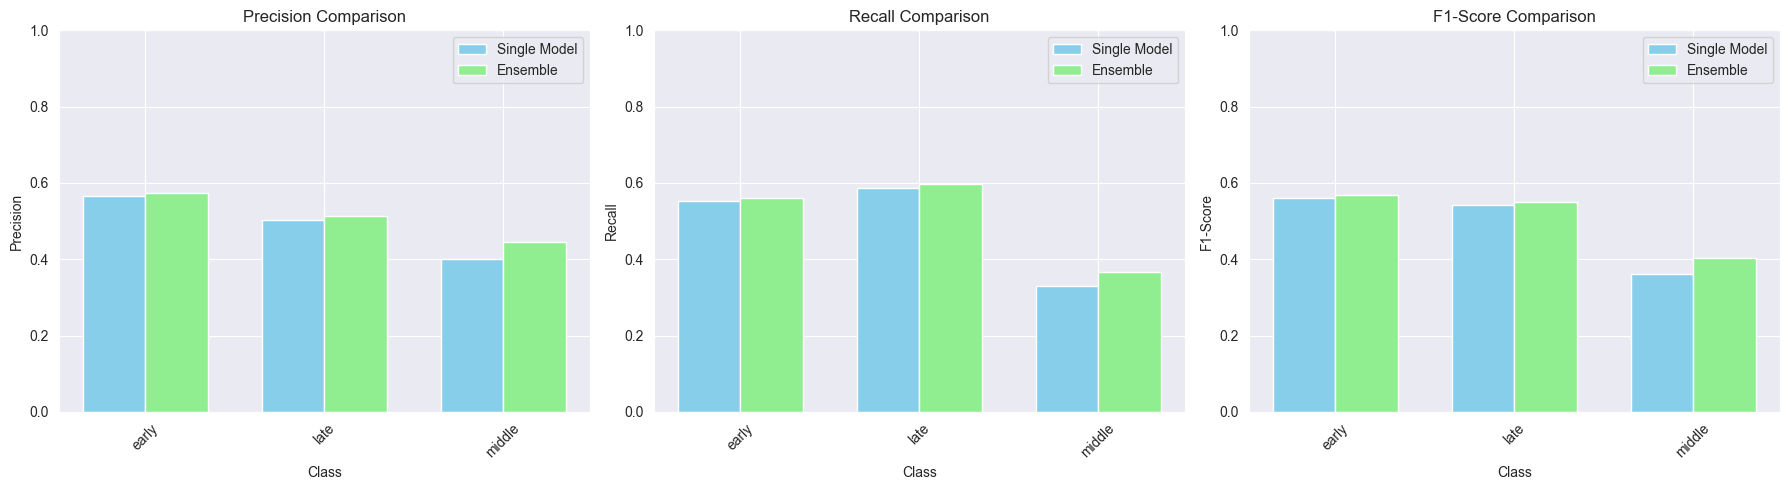

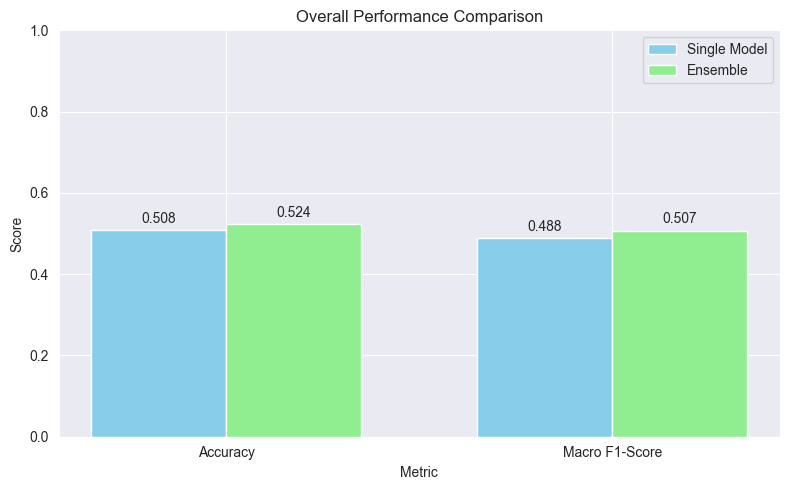

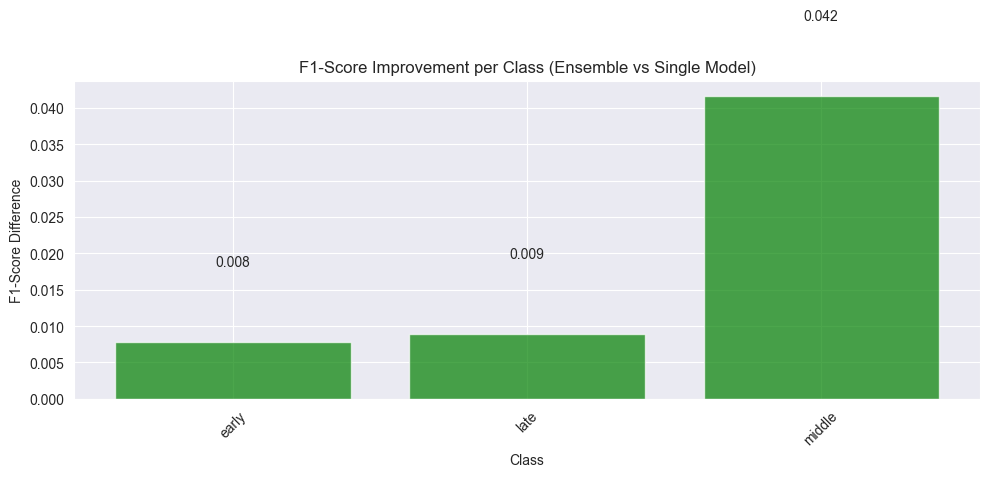


» Vergleich Single Model vs Ensemble (6B):
   Single Model  - Accuracy: 0.5080, Macro F1: 0.4879
   Ensemble      - Accuracy: 0.5240, Macro F1: 0.5073
   Verbesserung  - Accuracy: +0.0160, Macro F1: +0.0194


In [20]:
# Vorhersagen für beide FocalLoss-Modelle
y_pred_single = torch.argmax(model(torch.from_numpy(X_te_s).float().to(device)), 1).cpu().numpy()
y_pred_ensemble = y_pred_ens_focal

# 1) Vergleich der Confusion Matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Single Model Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax1,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
ax1.set_title(f"Single Model ({model_choice} - FocalLoss)")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")

# Ensemble Confusion Matrix
cm_ensemble = confusion_matrix(y_te, y_pred_ensemble)
sns.heatmap(cm_ensemble, annot=True, fmt="d", cmap="Greens", ax=ax2,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
ax2.set_title(f"Ensemble ({model_choice} - FocalLoss)")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True")

plt.tight_layout()
plt.show()

# 2) Performance-Vergleich pro Klasse
single_report = classification_report(y_te, y_pred_single, target_names=label_encoder.classes_, output_dict=True)
ensemble_report = classification_report(y_te, y_pred_ensemble, target_names=label_encoder.classes_, output_dict=True)

# Erstelle DataFrame für Vergleich
metrics_comparison = []
for cls in label_encoder.classes_:
    metrics_comparison.append({
        'Class': cls,
        'Single_Precision': single_report[cls]['precision'],
        'Ensemble_Precision': ensemble_report[cls]['precision'],
        'Single_Recall': single_report[cls]['recall'],
        'Ensemble_Recall': ensemble_report[cls]['recall'],
        'Single_F1': single_report[cls]['f1-score'],
        'Ensemble_F1': ensemble_report[cls]['f1-score']
    })

df_comparison = pd.DataFrame(metrics_comparison)

# Plot der Metriken-Vergleiche
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Precision Vergleich
x = np.arange(len(label_encoder.classes_))
width = 0.35
axes[0].bar(x - width/2, df_comparison['Single_Precision'], width, label='Single Model', color='skyblue')
axes[0].bar(x + width/2, df_comparison['Ensemble_Precision'], width, label='Ensemble', color='lightgreen')
axes[0].set_title('Precision Comparison')
axes[0].set_ylabel('Precision')
axes[0].set_xlabel('Class')
axes[0].set_xticks(x)
axes[0].set_xticklabels(label_encoder.classes_, rotation=45)
axes[0].legend()
axes[0].set_ylim(0, 1)

# Recall Vergleich
axes[1].bar(x - width/2, df_comparison['Single_Recall'], width, label='Single Model', color='skyblue')
axes[1].bar(x + width/2, df_comparison['Ensemble_Recall'], width, label='Ensemble', color='lightgreen')
axes[1].set_title('Recall Comparison')
axes[1].set_ylabel('Recall')
axes[1].set_xlabel('Class')
axes[1].set_xticks(x)
axes[1].set_xticklabels(label_encoder.classes_, rotation=45)
axes[1].legend()
axes[1].set_ylim(0, 1)

# F1-Score Vergleich
axes[2].bar(x - width/2, df_comparison['Single_F1'], width, label='Single Model', color='skyblue')
axes[2].bar(x + width/2, df_comparison['Ensemble_F1'], width, label='Ensemble', color='lightgreen')
axes[2].set_title('F1-Score Comparison')
axes[2].set_ylabel('F1-Score')
axes[2].set_xlabel('Class')
axes[2].set_xticks(x)
axes[2].set_xticklabels(label_encoder.classes_, rotation=45)
axes[2].legend()
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# 3) Gesamtperformance-Vergleich
single_acc = accuracy_score(y_te, y_pred_single)
ensemble_acc = accuracy_score(y_te, y_pred_ensemble)
single_f1 = single_report['macro avg']['f1-score']
ensemble_f1 = ensemble_report['macro avg']['f1-score']

metrics = ['Accuracy', 'Macro F1-Score']
single_scores = [single_acc, single_f1]
ensemble_scores = [ensemble_acc, ensemble_f1]

fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, single_scores, width, label='Single Model', color='skyblue')
ax.bar(x + width/2, ensemble_scores, width, label='Ensemble', color='lightgreen')

ax.set_title('Overall Performance Comparison')
ax.set_ylabel('Score')
ax.set_xlabel('Metric')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Werte als Text über den Balken
for i, (single, ensemble) in enumerate(zip(single_scores, ensemble_scores)):
    ax.text(i - width/2, single + 0.01, f'{single:.3f}', ha='center', va='bottom')
    ax.text(i + width/2, ensemble + 0.01, f'{ensemble:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 4) Verbesserung pro Klasse durch Ensemble
improvement = df_comparison['Ensemble_F1'] - df_comparison['Single_F1']
colors = ['red' if x < 0 else 'green' for x in improvement]

plt.figure(figsize=(10, 5))
bars = plt.bar(label_encoder.classes_, improvement, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.title('F1-Score Improvement per Class (Ensemble vs Single Model)')
plt.ylabel('F1-Score Difference')
plt.xlabel('Class')
plt.xticks(rotation=45)

# Werte über/unter den Balken
for bar, val in zip(bars, improvement):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.01),
             f'{val:.3f}', ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()

# Zusammenfassung ausgeben
print(f"\n» Vergleich Single Model vs Ensemble ({model_choice}):")
print(f"   Single Model  - Accuracy: {single_acc:.4f}, Macro F1: {single_f1:.4f}")
print(f"   Ensemble      - Accuracy: {ensemble_acc:.4f}, Macro F1: {ensemble_f1:.4f}")
print(f"   Verbesserung  - Accuracy: {ensemble_acc-single_acc:+.4f}, Macro F1: {ensemble_f1-single_f1:+.4f}")

# Vergleich MultiMarginLoss: Single vs Ensemble

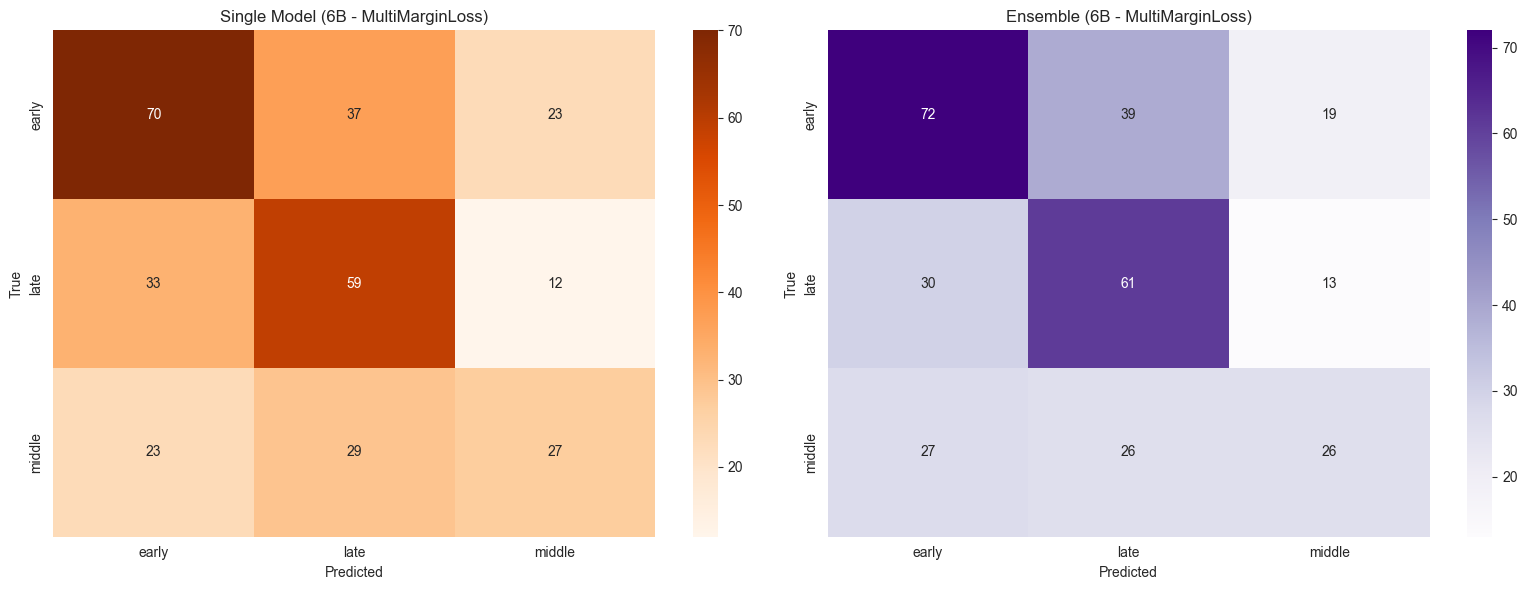

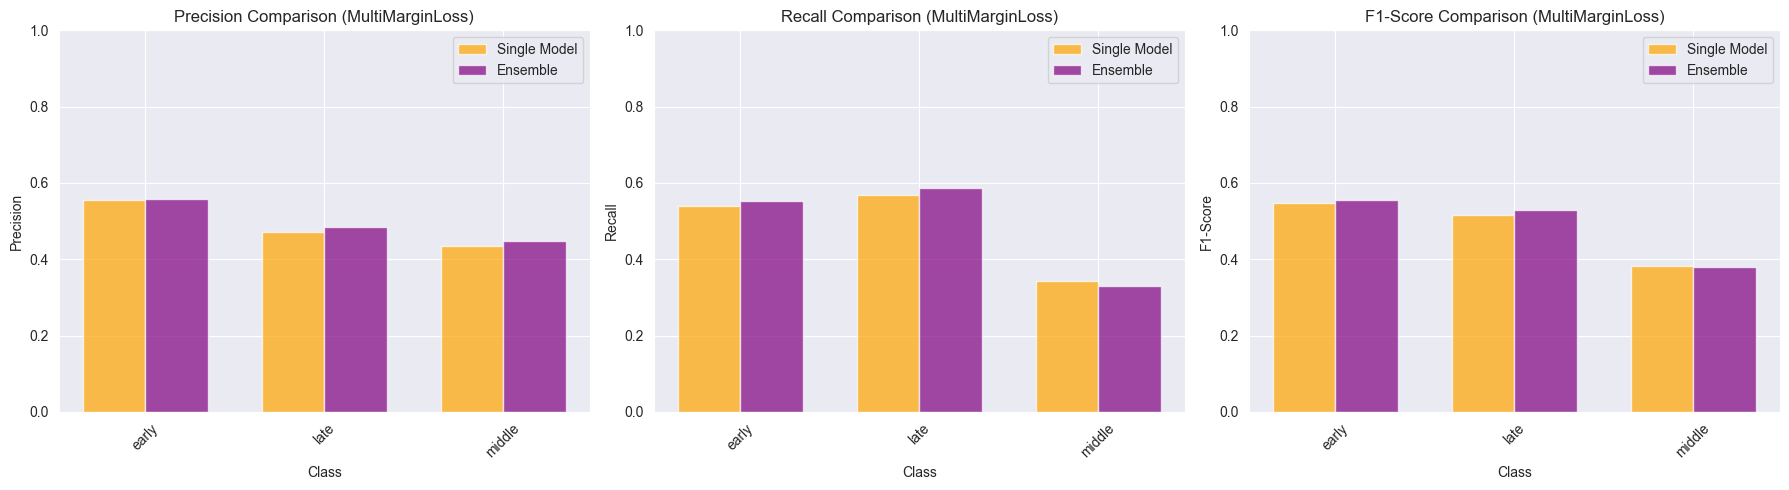

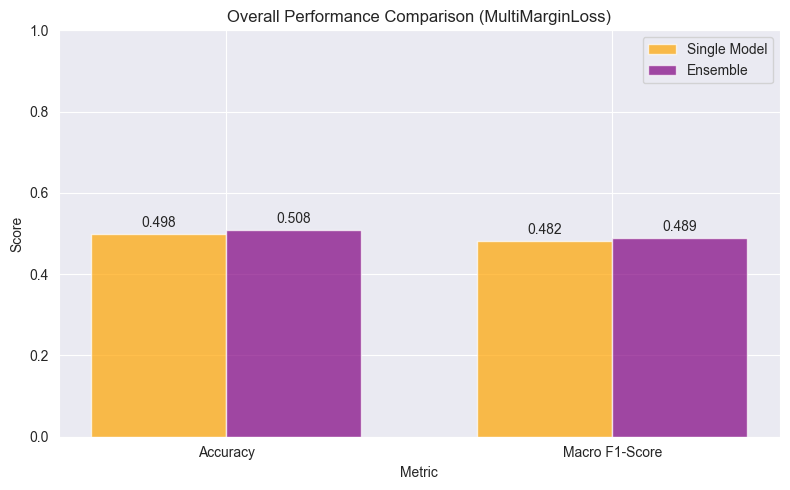

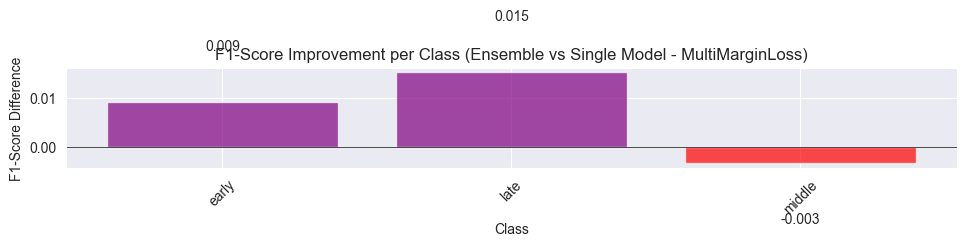


» Vergleich Single Model vs Ensemble (6B - MultiMarginLoss):
   Single Model  - Accuracy: 0.4984, Macro F1: 0.4817
   Ensemble      - Accuracy: 0.5080, Macro F1: 0.4887
   Verbesserung  - Accuracy: +0.0096, Macro F1: +0.0069


In [21]:
# Vorhersagen für beide MultiMarginLoss-Modelle
y_pred_single_margin = torch.argmax(model_margin(torch.from_numpy(X_te_s).float().to(device)), 1).cpu().numpy()
y_pred_ensemble_margin = y_pred_ens_margin

# 1) Vergleich der Confusion Matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Single MultiMarginLoss Model Confusion Matrix
sns.heatmap(cm_m, annot=True, fmt="d", cmap="Oranges", ax=ax1,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
ax1.set_title(f"Single Model ({model_choice} - MultiMarginLoss)")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")

# Ensemble MultiMarginLoss Confusion Matrix
cm_ensemble_margin = confusion_matrix(y_te, y_pred_ensemble_margin)
sns.heatmap(cm_ensemble_margin, annot=True, fmt="d", cmap="Purples", ax=ax2,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
ax2.set_title(f"Ensemble ({model_choice} - MultiMarginLoss)")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True")

plt.tight_layout()
plt.show()

# 2) Performance-Vergleich pro Klasse
single_margin_report = classification_report(y_te, y_pred_single_margin, target_names=label_encoder.classes_, output_dict=True)
ensemble_margin_report = classification_report(y_te, y_pred_ensemble_margin, target_names=label_encoder.classes_, output_dict=True)

# Erstelle DataFrame für Vergleich
metrics_comparison_margin = []
for cls in label_encoder.classes_:
    metrics_comparison_margin.append({
        'Class': cls,
        'Single_Precision': single_margin_report[cls]['precision'],
        'Ensemble_Precision': ensemble_margin_report[cls]['precision'],
        'Single_Recall': single_margin_report[cls]['recall'],
        'Ensemble_Recall': ensemble_margin_report[cls]['recall'],
        'Single_F1': single_margin_report[cls]['f1-score'],
        'Ensemble_F1': ensemble_margin_report[cls]['f1-score']
    })

df_comparison_margin = pd.DataFrame(metrics_comparison_margin)

# Plot der Metriken-Vergleiche
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Precision Vergleich
x = np.arange(len(label_encoder.classes_))
width = 0.35
axes[0].bar(x - width/2, df_comparison_margin['Single_Precision'], width, label='Single Model', color='orange', alpha=0.7)
axes[0].bar(x + width/2, df_comparison_margin['Ensemble_Precision'], width, label='Ensemble', color='purple', alpha=0.7)
axes[0].set_title('Precision Comparison (MultiMarginLoss)')
axes[0].set_ylabel('Precision')
axes[0].set_xlabel('Class')
axes[0].set_xticks(x)
axes[0].set_xticklabels(label_encoder.classes_, rotation=45)
axes[0].legend()
axes[0].set_ylim(0, 1)

# Recall Vergleich
axes[1].bar(x - width/2, df_comparison_margin['Single_Recall'], width, label='Single Model', color='orange', alpha=0.7)
axes[1].bar(x + width/2, df_comparison_margin['Ensemble_Recall'], width, label='Ensemble', color='purple', alpha=0.7)
axes[1].set_title('Recall Comparison (MultiMarginLoss)')
axes[1].set_ylabel('Recall')
axes[1].set_xlabel('Class')
axes[1].set_xticks(x)
axes[1].set_xticklabels(label_encoder.classes_, rotation=45)
axes[1].legend()
axes[1].set_ylim(0, 1)

# F1-Score Vergleich
axes[2].bar(x - width/2, df_comparison_margin['Single_F1'], width, label='Single Model', color='orange', alpha=0.7)
axes[2].bar(x + width/2, df_comparison_margin['Ensemble_F1'], width, label='Ensemble', color='purple', alpha=0.7)
axes[2].set_title('F1-Score Comparison (MultiMarginLoss)')
axes[2].set_ylabel('F1-Score')
axes[2].set_xlabel('Class')
axes[2].set_xticks(x)
axes[2].set_xticklabels(label_encoder.classes_, rotation=45)
axes[2].legend()
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# 3) Gesamtperformance-Vergleich
single_margin_acc = accuracy_score(y_te, y_pred_single_margin)
ensemble_margin_acc = accuracy_score(y_te, y_pred_ensemble_margin)
single_margin_f1 = single_margin_report['macro avg']['f1-score']
ensemble_margin_f1 = ensemble_margin_report['macro avg']['f1-score']

metrics = ['Accuracy', 'Macro F1-Score']
single_margin_scores = [single_margin_acc, single_margin_f1]
ensemble_margin_scores = [ensemble_margin_acc, ensemble_margin_f1]

fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, single_margin_scores, width, label='Single Model', color='orange', alpha=0.7)
ax.bar(x + width/2, ensemble_margin_scores, width, label='Ensemble', color='purple', alpha=0.7)

ax.set_title('Overall Performance Comparison (MultiMarginLoss)')
ax.set_ylabel('Score')
ax.set_xlabel('Metric')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Werte als Text über den Balken
for i, (single, ensemble) in enumerate(zip(single_margin_scores, ensemble_margin_scores)):
    ax.text(i - width/2, single + 0.01, f'{single:.3f}', ha='center', va='bottom')
    ax.text(i + width/2, ensemble + 0.01, f'{ensemble:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 4) Verbesserung pro Klasse durch Ensemble
improvement_margin = df_comparison_margin['Ensemble_F1'] - df_comparison_margin['Single_F1']
colors_margin = ['red' if x < 0 else 'purple' for x in improvement_margin]

plt.figure(figsize=(10, 5))
bars = plt.bar(label_encoder.classes_, improvement_margin, color=colors_margin, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.title('F1-Score Improvement per Class (Ensemble vs Single Model - MultiMarginLoss)')
plt.ylabel('F1-Score Difference')
plt.xlabel('Class')
plt.xticks(rotation=45)

# Werte über/unter den Balken
for bar, val in zip(bars, improvement_margin):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.01),
             f'{val:.3f}', ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()

# Zusammenfassung ausgeben
print(f"\n» Vergleich Single Model vs Ensemble ({model_choice} - MultiMarginLoss):")
print(f"   Single Model  - Accuracy: {single_margin_acc:.4f}, Macro F1: {single_margin_f1:.4f}")
print(f"   Ensemble      - Accuracy: {ensemble_margin_acc:.4f}, Macro F1: {ensemble_margin_f1:.4f}")
print(f"   Verbesserung  - Accuracy: {ensemble_margin_acc-single_margin_acc:+.4f}, Macro F1: {ensemble_margin_f1-single_margin_f1:+.4f}")

# Fazit

Das FocalLoss-Modell zeigt eine leichte Verbesserung der Macro-F1-Score im Vergleich zum MultiMarginLoss-Modell. Das Ensemble des FocalLoss-Modells erzielt eine weitere Steigerung der Performance, insbesondere in Bezug auf die Klassenbalance und die Robustheit gegenüber Ungleichgewichten in den Klassen. Middle ist als am schwächsten vertretene Klasse auch jene die am schlechtesten klassifiziert wird. Das Ensemble-Modell verbessert die Performance in dieser Klasse minimal, was auf die Vorteile des Ensembles hinweist.